# Job Shop Scheduling: Basics and State Space Search

The **job shop scheduling** problem is a classic AI planning, scheduling and combinatorial optimisation problem. It has many real-world applications in Industry 4.0, such as intelligent supply chain management, manufacturing and cloud computing. 

In this tutorial, we will introduce the **basics of job shop scheduling problem** and a simple **state space search** in AI planning to solve it.

-----------

# Table of Contents

1. [Job, Operation, Machine, Schedule](#concepts)
2. [State Space Search](#search)
    1. [Environment](#env)
    2. [State](#state)
    3. [Action](#action)
    4. [Overall Search Algorithm](#overall)
    5. [Computational Complexity](#complexity)
3. [Case Study in Car Manufacturing](#case)
4. [Display Schedule](#display)
5. [Jobs with Different Operation Sequences](#diffop)

-----------

## 1. Job, Operation, Machine, Schedule <a name = "concepts"></a>

Let's consider a car manufacturing factory. It receives **jobs** to build cars. For the sake of simplicity, we consider that building a car consists of the following a **sequence** of three main **operations**:

1. **Add Engine**: This is to add the engine to the car by an **Engine Hoist**;
2. **Add Wheels**: This is to add the wheels to the car by a **Wheel Station**;
3. **Inspect**: After the car has been built, it has to be inspected by an **Inspector**.

<img src="img/car-manufacturing.png" width=400 />

Each operation of each job has a **duration (processing time)**, and the required **machine/resource** to process it. For example, the `add_engine` operation requires the `engine_hoist` to process it, and the `inspect` operation is required to be processed by the `inspector`.

There are two constraints that a job shop schedule must satisfy:

1. **Resource Constraint**: each machine can process at most one operation at a time.
2. **Precedence Constraint**: each operation cannot start processing until its precedent operation in the same job has been completed (e.g., `add_wheels` cannot start until `add_engine` is completed). The first operation of a job can be started at time 0 (the job is already at the shop floor).

The goal of job shop scheduling is to find a schedule with the minimal **makespan** (the completion time of the last completed job), subject to the above resource and precedence constraints.

In the above car manufacturing example, let's assume that the factory has one `engine_hoist`, one `wheel_station` and one `inspector`, and there are two jobs described as follows:

| Job | Operation | Machine |  Duration |
| --- | --------- | ------- |  --------- |
| 1   | `add_engine_1` | `engine_hoist` | 30 |
|     | `add_wheels_1` | `wheel_station` | 30 |
|     | `inspect_1` |    `inspector` | 10 |
| 2   | `add_engine_2` | `engine_hoist` | 60 |
|     | `add_wheels_2` | `wheel_station` | 15 |
|     | `inspect_2` |    `inspector` | 10 |

Below shows the gantt chart of two possible feasible schedules. The first schedule has a makespan of 115, while the second one has a makespan of 130.

<img src="img/schedule1.png" width=600 />

<img src="img/schedule2.png" width=600 />

While `machine` can be defined straightforwardly, `operation` contains a number of properties. To wrap these properties, we can define an `operation` class in Python as follows.

In [1]:
class Operation:
    '''
    Construct an operation, including the following properties.
    - name of the operation
    - machine
    - duration (processing time)
    - prec (preceding operation)
    - succ (succeeding operation)
    '''
    def __init__(self, name, machine, duration, prec, succ):
        self.name = name
        self.machine = machine
        self.duration = duration
        self.prec = prec
        self.succ = succ

A `job` consists of a sequence/list of operations. It might also have other properties such as `arrival_time`, `due_date`, `weight` that reflects its importance/urgency, etc. To wrap the job attributes, we define a `job` class in Python as follows.

In [2]:
class Job:
    '''
    Construct a job, including the following properties.
    - job name
    - list of operations
    - arrival time, default to be 0
    - due date, default to be infinity
    - weight, default to be 1
    '''
    def __init__(self, name, operations):
        self.name = name
        self.operations = operations
        self.arrival_time = 0
        self.due_date = float('inf')
        self.weight = 1

A job shop can then be represented as a list of `machines` and a list of `jobs`.

In [3]:
class JobShop:
    '''
    Construct a job shop environment, including a list of machines and a list of jobs.
    '''
    def __init__(self, machines, jobs):        
        self.machines = machines
        self.jobs = jobs
        
        # We also create a hash map to quickly access operations if needed
        self.operations = {}
        for job in jobs:
            for op in job.operations:
                self.operations[op.name] = op

----------

## 2. State Space Search <a name="search"></a>

Following the AI planning paradigm, the **state space search** for schedules needs to define the (1) initial state, (2) goal states, and (3) set of actions. In addition, the search is in a job shop environment with a number of machines and jobs to be processed. To this end, we need to define **environment**, **state** and **action** for the state space search.

### 2.A. Environment <a name='env'></a>

The job shop environment consists of a number of machines and jobs. Each job has a sequencing of operations. This includes all the static information that remain unchanged during the search. In other words, the environment stores the attributes that are not changed by the actions.

Here, the job shop environment can be directly represented by the `JobShop` class defined above, as all the information there is not changed during the search.

### 2.B. State <a name="state"></a>

A job shop state should include the temporal states of each operation and each machine during the search, such as whether a machine is busy or idle, and when it will complete the current operation if it's busy, whether an operation is ready to be processed (i.e., its precedent operation has been completed) or not, etc. It should also include the current time and the schedule so far.

Here, we define the job shop **state** with the following attributes:

1. `machine_idle_time`: **the idle time of each machine**. If the idle time of a machine is earlier than the current time, then the machine is idle. Otherwise, the machine is busy with processing some operation. It will complete its operation and become idle again at its `machine_idle_time`.
2. `operation_ready_time`: **the ready time of each operation**. For the first operation of each job (with no precedent operation), its ready time is set to the job arrival time. Other operations are not ready yet, and their ready time can be treated as undefined (or $\infty$). Then, once an operation has been completed, the ready time of its next operation is updated with the completion time of the operation.
3. `schedule`: **the schedule so far**. It is initialised as empty (no operation has been scheduled). A complete schedule should have all the operations completed.
4. `completed`: **the list of completed operations**. In the initial state, no operation is completed. In a goal state, all the operation are completed.

We can define the `State` class in Python as follows.

In [4]:
class State:
    '''
    Initialise the state with the job shop, i.e., a list of machines and a list of operations.
    '''
    def __init__(self, job_shop):
        # 1. Initially, the idle time of all the machines are 0.
        self.machine_idle_time = {}
        for machine in job_shop.machines:
            self.machine_idle_time[machine] = 0 
        
        # 2. Initially, all the operations except the first operations of the jobs are not ready.
        # Their ready time are undefined, so not added into the operation_ready_time.
        self.operation_ready_time = {}
        for job in job_shop.jobs:
            self.operation_ready_time[job.operations[0].name] = job.arrival_time
        
        # 3. Initial schedule is empty
        self.schedule = []
        
        # 4. Initially, no operation is completed, and the list is empty.
        self.completed = []

Based on the above definition of state, we have the following definitions of **initial state** and **goal state**.

#### Initial State

The **initial state** has the following variable values:

- The **machine idle time** is 0 for all the machines;
- The **operation ready time** is the job arrival time for the first operation of all the jobs, and undefined (infinity) for all the other operations;
- The **schedule** is empty;
- The **list of completed jobs** is empty.

The initial state is generated by the above `State(job_shop)` construction method.

#### Goal State

A **goal state** satisfies the following condition:
- The **list of completed jobs** contains all the operations in the problem.

There can be many different goal states, each corresponding to a different schedule. To find the best schedule with the minimal makespan, we need to examine *ALL* the possible goal states and their schedule makespan.

### 2.C. Action <a name="action"></a>

An **action** in the state space search is to **start processing** an `operation` by a `machine` at a specific `time`. 

It can be denoted as `Process(operation, machine, time)`. For example, we may have `Process(add_engine_1, engine_hoist, 0)` and `Process(add_engine_2, engine_hoist, 60)` for the previous car manufacturing problem. 

For each action, the **precondition** (i.e., in which states the action is applicable) and **effect** (i.e., how the action updates the state when being applied) are given as follows.

#### Precondition

- `operation` is uncompleted, and is ready at `time`, i.e., `operation_ready_time[operation] <= time`.
- `machine` is idle at `time`, i.e., `machine_idle_time[machine] <= time`.

#### Effect

- `operation` becomes completed, i.e., `completed[operation] = True`.
- `machine` becomes busy, and its idle time is updated to `machine_idle_time[machine] = time + duration[operation]`.
- If `operation` is not the last operation in the job, then its next operation becomes ready once it is completed, i.e., `operation_ready_time[next[operation]] = time + duration[operation]`.

We can define the `Process` action class in Python as follows.

In [5]:
import copy

class Process:
    '''
    Construct a process with an operation, a machine and a time
    '''
    def __init__(self, operation, machine, time):
        self.operation = operation
        self.machine = machine
        self.time = time
    
    '''
    Check its precondition to see if it is applicable in a state.
    '''
    def is_applicable(self, state):
        # Check if the operation is completed or not.
        if self.operation.name in state.completed:
            return False
        
        # Check if the operation is ready now or not.
        if state.operation_ready_time[self.operation.name] > self.time:
            return False
        
        # Check if the machine is idle now or not.
        if state.machine_idle_time[self.machine] > self.time:
            return False

        return True
    
    '''
    Apply the processing action to a state, and return the resultant state.
    '''
    def apply(self, state):
        new_state = copy.deepcopy(state)
        
        # Add this process action to the schedule
        new_state.schedule.append(self)
        
        # The operation becomes completed
        new_state.completed.append(self.operation.name)
        
        # Delete the operation from operation_ready_time, since it is completed
        new_state.operation_ready_time.pop(self.operation.name)
        
        completion_time = self.time + self.operation.duration
        
        # The machine becomes busy, and will be idle again after the operation is completed
        new_state.machine_idle_time[self.machine] = completion_time
        
        # If the operation is not the last operation of the job, then its next operation becomes ready
        if self.operation.succ != None:
            new_state.operation_ready_time[self.operation.succ.name] = completion_time
        
        return new_state

### 2.D. Overall Search Algorithm <a name="overall"></a>

After designing the **state** and **action**, we now describe how to search for the best schedule in the state space.

Note that the space space can be seen as a graph, where each state is a node, and each action is an edge/link to connect the nodes/states. Here, we follow the general **graph search** process which maintains a **fringe** of states that represents the current frontier during the search process. At each step, we pick one state from the fringe (i.e., visit a branch) to continue the search. The search stops after all the possible solutions have been found, and the fringe becomes empty. 

The pseudo code of the state space search can be described as follows.

---------

```python
Generate an initial state, best_state = None, best_makespan = infinity
# Initialise the fringe with the initial state
fringe = [initial_state]

# Search by expanding a branch at each step
while fringe is not empty:
    Pick a state from fringe
    
    if state is a goal state:
        if state.schedule has a smaller makespan than best_makespan:
            best_state = state, best_makespan = makespan
    
    Find the applicable actions at state
    
    for action in applicable_actions:
        Apply action to state to generate next_state
        Add next_state into fringe

    remove state from fringe
return best_state.schedule
```

-------------

> Another commonly used graph search paradigm is based on recursion (e.g., recursively calling the search method at each node). Here we adopt the fringe-based graph search to facilitate other branching algorithms to be described later.

#### Applicable Actions for State

During the search process, an important step is to find the **applicable actions** for a state. By definition, a process action includes three components: `operation`, `machine` and `time`. While the first two components `operation` and `machine` are relatively straightforward from the ready operations and idle machines, the processing start `time` is not trivially defined. Specifically, we can start processing an operation with a machine any time after the operation is ready and the machine is idle. For example, if `operation` is ready at time 30 and `machine` is idle at time 40, then we can start processing `operation` by `machine` any time after time 40. This leads to infinite number of actions. 

To address this issue, we follow the common **non-delay** scheme, which means that no delay is allowed to process operations. In the above example where `operation` is ready at time 30 and `machine` is idle at time 40, there is *ONLY* one action `Process(operation, machine, 40)` under the non-delay scheme.

We can use the `Process.is_applicable()` method in the above `Process` class to check whether an action is applicable to a state.

The Python code for finding all the applicable actions for a state in a job shop environment can be written as follows.

In [6]:
def applicable_actions(state, job_shop):
    actions = []
    
    # Enumerate all the operations in the operation_ready_time map.
    # For efficiency, this map ignores the operations whose ready time are still infinity 
    # (they are not applicable anyway).
    for opname in state.operation_ready_time.keys():
        op = job_shop.operations[opname]
        
        time = state.operation_ready_time[opname]
        
        if time < state.machine_idle_time[op.machine]:
            time = state.machine_idle_time[op.machine]
            
        action = Process(op, op.machine, time)
        
        if action.is_applicable(state):
            actions.append(action)
    
    return actions

#### Goal State Check

A state is a goal state if all the operations have been completed. This can be easily checked by
```python
if len(state.completed) == len(operations)
```

#### Schedule Makespan Calculation

For each found goal state, we need to compare the corresponding schedule with the best schedule found so far. Specifically, we need to calculate the makespan of the schedule. Here, **a schedule is represented as a list of processing actions (the start time for processing each operation)**. The makespan is calculated as the maximal completion time of all the operations as follows.

In [7]:
def makespan(schedule):
    makespan = 0
    
    for action in schedule:
        completion_time = action.time + action.operation.duration
        
        if completion_time > makespan:
            makespan = completion_time
    
    return makespan

Taking the above into account, the Python code of the overall state space search algorithm is given as follows.

In [8]:
def state_space_search(job_shop):
    # Initialise the state and fringe
    init_state = State(job_shop)
    best_state = None
    best_makespan = float('inf')
    fringe = [init_state]
    
    while len(fringe) > 0:
        state = fringe[0] # arbitrarily pick the first state in the fringe
        
        # We have found a new goal state
        if len(state.completed) == len(job_shop.operations):
            new_makespan = makespan(state.schedule)
            
            if new_makespan < best_makespan:
                best_state = state
                best_makespan = new_makespan
        
        actions = applicable_actions(state, job_shop)
        for a in actions:
            next_state = a.apply(state)
            fringe.append(next_state)
        
        fringe.remove(state)
    
    return best_state.schedule

### 2.E. Computational Complexity <a name='complexity'></a>

Assume that there are $N$ jobs and $M$ machines. Each job has $M$ operations, each to be processed by a different machine. There are $NM$ operations in total.

At each state, there can be at most $N$ applicable actions, as each job can have an operation ready. In other words, each node in the search tree has $O(N)$ branches. 

Each action completes an operation. Thus, it takes $NM$ actions from the initial state to a goal state. In other words, the depth of the tree is $NM$.

Therefore, to enumerate all the leaf nodes (goal states) of the search tree, one has to visit all the nodes in the search tree, which has a computational complexity of 

$$
O(1 + N + N^2 + \dots + N^{NM}) \approx O(N^{NM}).
$$

--------------------

## 3. Case Study in Car Manufacturing <a name="case"></a>

Now, let's test this `state_space_search()` method to the above car manufacturing problem with two jobs. First, we input the problem data as follows.

In [9]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

add_engine_1 = Operation('add_engine_1', 'engine_hoist', 30, None, None)
add_wheels_1 = Operation('add_wheels_1', 'wheel_station', 30, add_engine_1, None)
inspect_1 = Operation('inspect_1', 'inspector', 10, add_wheels_1, None)
add_engine_2 = Operation('add_engine_2', 'engine_hoist', 60, None, None)
add_wheels_2 = Operation('add_wheels_2', 'wheel_station', 15, add_engine_2, None)
inspect_2 = Operation('inspect_2', 'inspector', 10, add_wheels_2, None)

add_engine_1.succ = add_wheels_1
add_wheels_1.succ = inspect_1
add_engine_2.succ = add_wheels_2
add_wheels_2.succ = inspect_2

job_1 = Job('job_1', [add_engine_1, add_wheels_1, inspect_1])
job_2 = Job('job_2', [add_engine_2, add_wheels_2, inspect_2])

job_shop = JobShop(machines, [job_1, job_2])

Then we run the `state_space_search()` method to obtain the `schedule`.

In [10]:
schedule = state_space_search(job_shop)
print("======= start printing state schedule ======")
for a in schedule:
    print(f'{a.operation.name}: {a.time} --> {a.time + a.operation.duration}')
print("======= finish printing state schedule ======")
print(f'makespan = {makespan(schedule)}')

======= start printing state schedule ======
add_engine_1: 0 --> 30
add_engine_2: 30 --> 90
add_wheels_1: 30 --> 60
add_wheels_2: 90 --> 105
inspect_1: 60 --> 70
inspect_2: 105 --> 115
======= finish printing state schedule ======
makespan = 115


-------------

## 4. Display Schedule <a name="display"></a>

Now we want to display the schedule. To this end, we first convert the schedule into a Pandas data frame, which is easy to process. To this end, we design the following `schedule_data_frame()` method to convert a schedule to a corresponding data frame.

In [11]:
import pandas as pd

def schedule_data_frame(schedule):
    # Convert each action to dictionary
    schedule_dict = []
    for action in schedule:
        a_dict = {
            'Operation': action.operation.name,
            'Machine': action.machine,
            'Start': action.time,
            'Duration': action.operation.duration,
            'Finish': action.time + action.operation.duration
        }
        schedule_dict.append(a_dict)
    
    return pd.DataFrame(schedule_dict)

### Data Frame Display

After converting to data frame, a straightforward display is to directly show the data frame in different orders, such as **schedule by operation** and **schedule by machine**. Below is the example of the two display methods.

In [12]:
def display(schedule):
    df = schedule_data_frame(schedule)

    print('\nSchedule by Operation')
    print(df.sort_values(by=['Operation','Start']).set_index(['Operation', 'Machine']))

    print('\nSchedule by Machine')
    print(df.sort_values(by=['Machine','Start']).set_index(['Machine', 'Operation']))

display(schedule)


Schedule by Operation
                            Start  Duration  Finish
Operation    Machine                               
add_engine_1 engine_hoist       0        30      30
add_engine_2 engine_hoist      30        60      90
add_wheels_1 wheel_station     30        30      60
add_wheels_2 wheel_station     90        15     105
inspect_1    inspector         60        10      70
inspect_2    inspector        105        10     115

Schedule by Machine
                            Start  Duration  Finish
Machine       Operation                            
engine_hoist  add_engine_1      0        30      30
              add_engine_2     30        60      90
inspector     inspect_1        60        10      70
              inspect_2       105        10     115
wheel_station add_wheels_1     30        30      60
              add_wheels_2     90        15     105


### Gantt Chart Plot

A better visualisation method is to draw the gantt chart of the schedule. For this purpose, we need to use the `matplotlib` Python library. We first install this library.

In [13]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Then we design the following `visualise()` method to plot the gantt chart of the schedule.

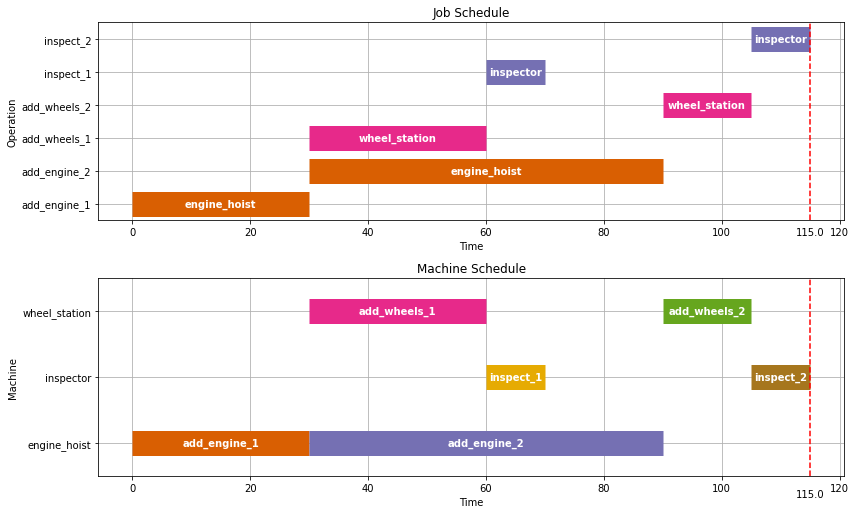

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def visualise(schedule):
    schedule = schedule_data_frame(schedule)
    
    JOBS = sorted(list(schedule['Operation'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Operation', 'Start'])
    schedule.set_index(['Operation', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Operation')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

visualise(schedule)

--------------

## 5. Jobs with Different Operation Sequences <a name='diffop'></a>

In job shop scheduling, different jobs can have different operation sequences. For example, in the car manufacturing problem, we can have one job with the sequence of [`add_engine` $\rightarrow$ `add_wheels` $\rightarrow$ `inspect`], and another job with [`add_wheels` $\rightarrow$ `add_engine` $\rightarrow$ `inspect`].

The state space search can be directly applied to job shop scheduling with any operation sequences.

To show an example, we create the following job shop scheduling instance (`add_engine_2` and `add_wheels_2` are swapped in job 2):


| Job | Operation | Machine |  Duration |
| --- | --------- | ------- |  --------- |
| 1   | `add_engine_1` | `engine_hoist` | 30 |
|     | `add_wheels_1` | `wheel_station` | 30 |
|     | `inspect_1` |    `inspector` | 10 |
| 2   | `add_wheels_2` | `wheel_station` | 15 |
|     | `add_engine_2` | `engine_hoist` | 60 |
|     | `inspect_2` |    `inspector` | 10 |

In [15]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

add_engine_1 = Operation('add_engine_1', 'engine_hoist', 30, None, None)
add_wheels_1 = Operation('add_wheels_1', 'wheel_station', 30, add_engine_1, None)
inspect_1 = Operation('inspect_1', 'inspector', 10, add_wheels_1, None)
add_wheels_2 = Operation('add_wheels_2', 'wheel_station', 15, None, None)
add_engine_2 = Operation('add_engine_2', 'engine_hoist', 60, add_wheels_2, None)
inspect_2 = Operation('inspect_2', 'inspector', 10, add_engine_2, None)

add_engine_1.succ = add_wheels_1
add_wheels_1.succ = inspect_1
add_wheels_2.succ = add_engine_2
add_engine_2.succ = inspect_2

job_1 = Job('job_1', [add_engine_1, add_wheels_1, inspect_1])
job_2 = Job('job_2', [add_wheels_2, add_engine_2, inspect_2])

job_shop_2 = JobShop(machines, [job_1, job_2])

Then we run the state space search algorithm and visualise the gantt chart of the found best schedule.

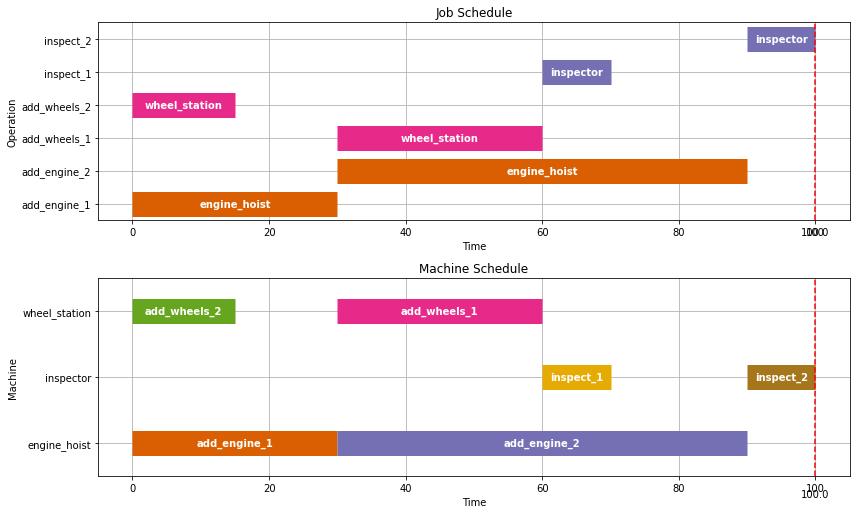

In [16]:
schedule_2 = state_space_search(job_shop_2)
visualise(schedule_2)

---------------

The original Juypter Notebook can be downloaded [here](https://homepages.ecs.vuw.ac.nz/~yimei/tutorials/job-shop-scheduling-state-space-search.ipynb).

More tutorials can be found [here](https://meiyi1986.github.io/tutorials/).

[Yi Mei's homepage](https://meiyi1986.github.io/)